# HyLands: modelling the evolution of landscapes and mass movements

This notebook provides a brief introduction and user's guide to the HyLands Hybrid Landscape Evolution model. The model simulates both continuous fluvial incision and sediment transport using the Landlab Space component as well as stochastic deep-seated bedrock landsliding using the Landlab BedrockLandslider component. This notebook combines two documents, a User's Manual and a notebook-based example, written Benjamin Campforts to accompany the following publications:

* Campforts, B., Shobe, C. M., Overeem, I., & Tucker, G. E. (2022). The Art of Landslides: How Stochastic Mass Wasting Shapes Topography and Influences Landscape Dynamics. Journal of Geophysical Research: Earth Surface, 127(8), 1–16. [doi: 10.1029/2022JF006745](https://doi.org/10.1029/2022JF006745)
* Campforts B., Shobe C.M., Steer P., Vanmaercke M., Lague D., Braun J. (2020) HyLands 1.0: a hybrid landscape evolution model to simulate the impact of landslides and landslide-derived sediment on landscape evolution. Geosci Model Dev: 13(9):3863–86, [doi: 10.5194/gmd-13-3863-2020](https://doi.org/10.5194/gmd-13-3863-2020).

## Background on BedrockLandslider component

The Landlab BedrockLandslider (Hybrid Landscape evolution model) component computes stochastic deep-seated bedrock landsliding and landslide-derived sediment runout across two-dimensional model landscapes. 

This user manual teaches users how to use the BedrockLandslider component using two examples. BedrockLandslider tracks both bedrock and sediment elevation through time. Ideally, a fluvial incision code tracking both bedrock incision and sediment transport is used. Throughout this notebook, we will use the Landlab SPACE component for that purpose. The user is motivated to check out the SPACE notebook before applying the BedrockLandslider component ([see notebook on SPACE](../space/SPACE_user_guide_and_examples.ipynb) and [notebook on SPACELargeScaleEroder](../space/SPACE_large_scale_eroder_user_guide_and_examples.ipynb)).

Prerequisites: A working knowledge of the Python programming language (BedrockLandslider and Landlab support Python 3.x) as well as the NumPy and MatPlotLib libraries. Basic familiarity with the Landlab modeling toolkit (see Hobley et al., 2017 GMD, and Barnhart et al., 2020 eSurf) is recommended.

## Model description

### Input parameters

- **angle_int_frict** $\psi$: Materials angle of internal friction in [m/m]. Default = 1.0
- **cohesion_eff** $c_{eff}$: Effective cohesion of material [m L^-1 T^-2].
- **landslides_return_time** $t_{LS}$: Return time for stochastic landslide events to occur [yr]. Default = 1e5
- **rho_r** $\rho_r$: Bulk density rock [m L^-3].
- **fraction_fines_LS** $F_f$: Fraction of permanently suspendable fines in bedrock [-].
- **phi** $\phi$: Sediment porosity [-].        
- **max_pixelsize_landslide**: Maximum size for landslides in number of pixels. Default = 1e9
- **verbose_landslides**: Print output as number of simulated landslides per time step. Default = False  
- **seed**: Provide seed to set stochastic model. If not provided, seed is set to 2021.Provide None to keep current seed. Default = 2021 
- **landslides_on_boundary_nodes**: Allow landslides to initiate (critical node) and extend over boundary nodes. Default = True
- **critical_sliding_nodes**: Provide list with critical nodes where landslides have to initiate. This cancels the stochastic part of the algorithm and allows the user to form landslides at the provided critical nodes. Default = None

### Model fields 
Fields listed here are updated by the component at the grid locations listed. NOTE: because flow routing is handled by other Landlab components, fields such as `flow__receiver_node`, `flow__upstream_node_order`, `flow__receiver_node`, `topographic__steepest_slope`, `hill_flow__receiver_proportions`, `hill_topographic__steepest_slope` and `hill_flow__receiver_node` are not altered by the BedrockLandslider model and are not listed here but required to run the model.

- `soil__depth`, node, [m]: Thickness of soil (also called sediment or alluvium) at every node. The name “soil” was used to match existing Landlab components. Soil thickness is updated for all nodes impacted by landsliding.

- `sediment__flux`, node, [m$^3$/yr]: The volumetric flux of sediment at each node. Sediment flux is updated based on the volumes of landslide-derived sediment and is used to calculate sediment deposition rates.

- `landslide__erosion`, node, [m]: Erosion by landslides given in total erosion in m per node. 

- `landslide__deposition`, node, [m]: Sediment erosion by landslides given in total erosion in m per node. 

- `landslide_sediment_point_source`, node, [m3]: Landslide derived sediment, as point sources on all the critical nodes where landslides initiate, before landslide runout is calculated.

### Model attributes
Other model attributes created upon model initiation and updated when executing run_one_step are: 
- `landslides_size`: List with the size of simulated landslides. The list is reset every time the landslide_erosion function is called.

- `landslides_volume`: List with the volume of simulated landslides.The list is reset every time the landslide_erosion function is called. 

- `landslides_volume_sed`: List with the volume of sediment eroded by landslides. The list is reset every time the landslide_erosion function is called.

- `landslides_volume_bed`: List with the volume of bedrock eroded by landslides. The list is reset every time the landslide_erosion function is called.

## Steps of a BedrockLandslider model

Note: these steps are for a BedrockLandslider model that is coupled to the SPACE Landlab component. To see examples of how to couple other Landlab components, please refer to the Landlab documentation: [http://landlab.github.io](http://landlab.github.io).

### Step 1: Import the necessary libraries 

The BedrockLandslider and SPACE components are required, as are the model grid component and a flow routing component. We will use the `PriorityFloodFlowRouter` that takes care of routing flow across flats or pits in a digital elevation model.

In [1]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt  # For plotting results; optional
import numpy as np

from landlab import RasterModelGrid  # Grid utility
from landlab import imshow_grid, imshowhs_grid  # For plotting results; optional
from landlab.components import BedrockLandslider  # BedrockLandslider model
from landlab.components import SpaceLargeScaleEroder  # SPACE model
from landlab.components import PriorityFloodFlowRouter

Three Landlab components are essential to running the BedrockLandslider model: the model itself, the SPACE model and the `PriorityFloodFlowRouter`, which calculates drainage pathways, topographic slopes, and surface water discharge across the grid. The `PriorityFloodFlowRouter` will act as a depression handler which is useful if a grid is likely to have pits or closed depressions. 

In addition to the relevant process components, some Landlab utilities are required to generate the model grid (in this example `RasterModelGrid`) and to visualize output (`imshowhs_grid`). Note that while it is possible to visualize output through functionality in other libraries (e.g., matplotlib), `imshowhs_grid` provides a simple way to generate 2-D maps of model variables.

Most Landlab functionality requires the Numpy package for scientific computing in python. The matplotlib plotting library has also been imported to aid visualization of results.

### Step 2: Define the model domain and initial conditions

The BedrockLandslider and SPACE components work on raster grids. For this example we will use a synthetic raster grid. In addition to using user-defined, synthetic model grids, it is also possible to import digital elevation models for use as a model domain (see the tutorial *reading_dem_into_landlab*). In this example, we create a synthetic, square model domain by creating an instance of the RasterModelGrid. In this case, the domain will be a plane with random micro-scale topographic roughness to force flow convergence and channelization, and the development of realistic landscapes. The grid is composed of 50 rows and 50 columns for a total of 250 nodes, with user-defined spacing of 25m.

Once the grid has been created, the user defines a grid field to contain values of land surface elevation, and then imposes the desired initial condition topography on the model grid. In the case shown below, the field `topographic__elevation` is added to the model grid and given initial values of all zeros. After that, initial model topography is added to the field. Randomized micro-scale topographic roughness is added to the model grid. While not strictly necessary for the SPACE and BedrockLandslider models to run, the micro-roughness allows flow convergence, channelization, and the development of realistic landscapes.

In this example, we initialize the model domain with 2 meters of sediment thickness at every core (non-boundary) node. The sediment thickness will shrink over time as water mobilizes and removes sediment. To do this, the fields `soil__depth` and `bedrock__elevation` must be added to the model grid. If they are not added, the SPACE model will create them. In that case, however, the default sediment thickness is zero and the default bedrock topography is simply the provided topographic elevation.

In [2]:
# Set grid parameters
num_rows = 50
num_columns = 50
node_spacing = 25.0

# track sediment flux at the node adjacent to the outlet at lower-left
node_next_to_outlet = num_columns + 1

# Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)
# add field ’topographic elevation’ to the grid
mg.add_zeros("node", "topographic__elevation")
# set constant random seed for consistent topographic roughness
np.random.seed(seed=5000)

# Create initial model topography:

# add topographic roughness
random_noise = (
    np.random.rand(len(mg.node_y)) / 1000.0
)  # impose topography values on model grid
mg["node"]["topographic__elevation"] += random_noise

# add field 'soil__depth' to the grid
mg.add_zeros("node", "soil__depth")

# Set 2 m of initial soil depth at core nodes
mg.at_node["soil__depth"][mg.core_nodes] = 1.0  # meters

# Add field 'bedrock__elevation' to the grid
mg.add_zeros("bedrock__elevation", at="node")

# Sum 'soil__depth' and 'bedrock__elevation'
# to yield 'topographic elevation'
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"]
mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

### Step 3: Set the boundary conditions

The user must determine the boundary conditions of the model domain (i.e., determine across which boundaries water and sediment may flow). Boundary conditions are controlled by setting the status of individual nodes or grid edges (see Hobley et al., 2017). Here, we keep all boundaries open so that water and sediment can leave the domain at all times over all edges. 

In [3]:
# Open all model boundary edges
mg.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=False,
    left_is_closed=False,
    right_is_closed=False,
    top_is_closed=False,
)

### Step 4: Initialize the flow director and SPACE 

Like most Landlab components, PriorityFloodFlowRouter, SPACE and BedrockLandslider are written as a Python classes. The class was imported at the beginning of the driver script (step 1). In this step, the user declares the instance of the PriorityFloodFlowRouter and SPACE classes and sets any relevant model parameters. At this point we do not yet make an instance of the BedrockLandslider component. 

In [4]:
# Instantiate flow router
fr = PriorityFloodFlowRouter(mg, flow_metric="D8", suppress_out=True)

# Instantiate SPACE model with chosen parameters
sp = SpaceLargeScaleEroder(
    mg,
    K_sed=2.5e-5,
    K_br=2.5e-5,
    F_f=0.0,
    phi=0.0,
    H_star=1.0,
    v_s=1,
    m_sp=0.5,
    n_sp=1.0,
    sp_crit_sed=0,
    sp_crit_br=0,
)

ModuleNotFoundError: PriorityFloodFlowRouter requires richdem but richdem is not installed. You can install richdem either from source (https://github.com/r-barnes/richdem), or through conda (conda install richdem -c conda-forge) or pip (pip install richdem).

### Step 5: Run the time loop to develop a landscape without landslide activity

The SPACE component calculates sediment entrainment and deposition, bedrock erosion, and changes in land surface elevation over time. The code shown below is an example of how to run the SPACE model over several model timesteps. In the example below, SPACE is run in a loop that executes until elapsed model time has reached a user-defined run time. The user is also responsible for choosing the model timestep. Within the loop, the following steps occur:

1. The flow router runs first to determine topographic slopes and water discharge at all nodes on the model domain.
2. The depression finder and router runs to map any nodes located in local topographic minima (i.e., nodes that water cannot drain out of) and to establish flow paths across the surface of these “lakes.” Using the depression finder and router is optional. However, because the SPACE model may in certain situations create local minima, using the depression finder and router can prevent the development of fatal instabilities.
3. The depression finder and router generates a list of flooded nodes, which is then saved as a variable called “flooded” and passed to the SPACE model.
4. The SPACE model runs for the duration of a single timestep, computing sediment transport, bedrock erosion, and topographic surface evolution.
5. The elapsed time is updated.

In [5]:
# Set model timestep
timestep = 1e3  # years

# Set elapsed time to zero
elapsed_time = 0.0  # years

# Set timestep count to zero
count = 0

# Set model run time
run_time = 5e5  # years

# Array to save sediment flux values
sed_flux = np.zeros(int(run_time // timestep))

# Uplift rate in m/yr
U = 1e-3

cmap = copy.copy(mpl.colormaps["terrain"])

while elapsed_time < run_time:  # time units of years
    # Insert uplift at core nodes
    mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
    mg.at_node["topographic__elevation"][:] = (
        mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
    )

    # Run the flow router
    fr.run_one_step()

    # Run SPACE for one time step
    sp.run_one_step(dt=timestep)

    # Add to value of elapsed time
    elapsed_time += timestep

    if np.mod(elapsed_time, 1e5) == 0:
        print("%.2f of model run completed" % (elapsed_time / run_time))
        imshow_grid(
            mg, "topographic__elevation", cmap=cmap, colorbar_label="Elevation (m)"
        )
        plt.show()

NameError: name 'fr' is not defined

## Visualization of results

### Topography and soil depth

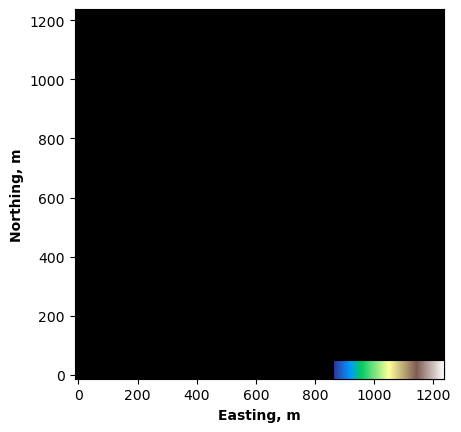

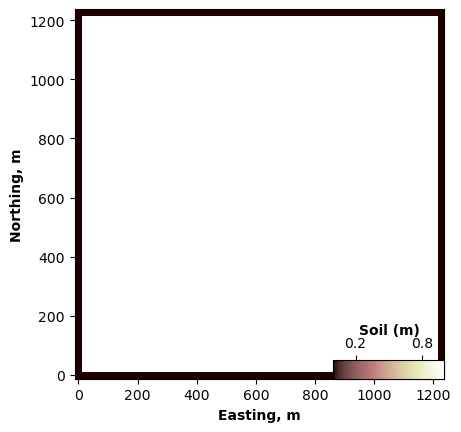

In [6]:
cmap = copy.copy(mpl.colormaps["terrain"])
# Show DEM draped over the shaded topographic relief
imshowhs_grid(
    mg,
    "topographic__elevation",
    var_name="Topo",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap=cmap,
    ticks_km=False,
)
plt.show()
# Show Soil thickness draped over the shaded topographic relief
cmap = copy.copy(mpl.colormaps["pink"])
imshowhs_grid(
    mg,
    "topographic__elevation",
    drape1=mg.at_node["soil__depth"],
    plot_type="Drape1",
    var_name="Soil",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap=cmap,
    ticks_km=False,
)

z_before_LS = np.array(mg["node"]["topographic__elevation"])

### Step 6: Initialize the flow director and SPACE and BedrockLandslider components

BedrockLandslider is written as a Python class. The class was imported at the beginning of the driver script (step 1). 
In this step, the user declares the instance of the BedrockLandslider class and sets any relevant model parameters. 
To calculate landslide runout, a non-local deposition scheme is used that requires a multiple flow direction structure. This is to ensure that landslide-derived sediment can be distributed over all 8 neighboring cells and not just to it's steepest neighbor as would be the case with a D8 flow routing algorithm. The priority flood flow router is designed as such that both fluvial (D8) and hillslope (multiple flow directions) can be calculated in the same go. To do this, we re-instantiate the flow router first before making an instance of the BedrockLandslider model. This will create the required fields (`hill_flow__receiver_node` and `hill_flow__receiver_proportions` and `hill_topographic__steepest_slope`) for the BedrockLandslider model. 

In [ ]:
# Instantiate flow router, with additional multiple flow director for hillslopes
fr = PriorityFloodFlowRouter(
    mg,
    flow_metric="D8",
    separate_hill_flow=True,
    hill_flow_metric="Quinn",
    update_hill_flow_instantaneous=True,
)

# Instantiate SPACE model with chosen parameters
hy = BedrockLandslider(
    mg,
    angle_int_frict=0.4,
    cohesion_eff=1e3,
    landslides_return_time=1000,
    landslides_on_boundary_nodes=False,
)

### Step 7: Run the time loop over 200 years to develop a landscape with landslide activity

Like before, uplift will be inserted, the flow routers will be updated and the SAPCELargeScaleEroder will be run, but this time, landslides will be actively simulated.  

In [ ]:
# Reset elevation back to elevation simulated without landslides to test various landslide configuration settings

mg["node"]["topographic__elevation"][:] = z_before_LS
timestep = 20  # years
landslides_size_all_steps = []

for i in range(10):
    # Insert uplift at core nodes
    mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
    mg.at_node["topographic__elevation"][:] = (
        mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
    )

    # Run the flow router
    fr.run_one_step()

    # Run SPACE for one time step
    sp.run_one_step(dt=timestep)

    # Run BedrockLandslider for one time step
    hy.run_one_step(dt=timestep)

    # Store landslide sizes of current time step into general ls_size list
    landslides_size_all_steps = np.append(landslides_size_all_steps, hy.landslides_size)

## Visualization of results
### Magnitude frequency of landslides simulated over 200 years

In [ ]:
LS_size = landslides_size_all_steps * mg.dx**2
counts, bins = np.histogram(np.log10(LS_size), 10)
plt.hist(np.log10(LS_size), log=True, bins=bins, density=True)
plt.xlabel("log10 LS Area, m2")
plt.ylabel("Landslide frequency")

### Location of landslides during last model iteration
Let's plot the resulting landslides 

In [ ]:
# Landslide Erosion
cmap = copy.copy(mpl.colormaps["hot_r"])
imshow_grid(
    mg,
    np.sqrt(mg.at_node["landslide__erosion"]),
    colorbar_label="SQRT( Landslide erosion, m) ",
    cmap=cmap,
)
plt.show()

# Landslide Deposition
cmap = copy.copy(mpl.colormaps["winter_r"])
imshow_grid(
    mg,
    np.sqrt(mg.at_node["landslide__deposition"]),
    colorbar_label="SQRT( Landslide deposition, m) ",
    cmap=cmap,
)
plt.show()

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>